In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
from torch.nn.functional import conv2d

In [2]:
from crf.crf import *
from crf.utils import read_image, read_pfm
#from sklearn.feature_extraction.image import extract_patches_2d

In [59]:
img1 = read_image('imL.png')#[::2,::2]
img2 = read_image('imR.png')#[::2,::2]
#img1 = read_image('im0.png')[::3,::3]
#img2 = read_image('im1.png')[::3,::3]
gt_depth = read_pfm('disp0.pfm')[::3,::3]

In [60]:
conv = sp.ndimage.filters.convolve

def normalized(img,window_size=9):
    box = np.ones((window_size,window_size,1))/window_size**2
    mean = conv(img,box)
    diff = img-mean
    std = np.sqrt(conv(diff**2, box))
    normalized_img = diff/std
    return normalized_img

def SD(imga,imgb):
    return (imga-imgb)**2
def AD(imga,imgb):
    return np.abs(imga-imgb)
def nprod(imga,imgb):
    return -1*imga*imgb

In [63]:
max_disp=30
ws = 11

nimg1 = normalized(img1,ws)
nimg2 = normalized(img2,ws)

h,w,c = nimg1.shape
padded_im1 = np.pad(nimg1,((0,0),(max_disp,0),(0,0)), mode='constant')
padded_im2 = np.pad(nimg2,((0,0),(max_disp,0),(0,0)), mode='constant')

out = np.zeros((h,w,max_disp))
for i in np.arange(max_disp):#1+np.arange(-w//2,w//2):
    shifted_nimg2 = padded_im2[:,max_disp-i:w+max_disp-i]
    out[:,:,i] = AD(nimg1,shifted_nimg2).sum(2)

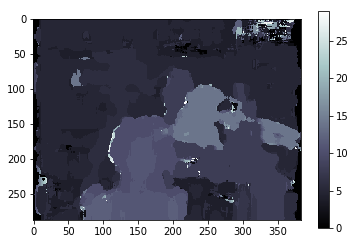

In [71]:
box = np.ones((ws,ws,1))
aggregated = sp.ndimage.filters.convolve(out,box)
disps = np.argmin(aggregated,axis=-1)#*(1+.5*np.arange(max_disp)/max_disp),axis=-1)
plt.imshow(disps,cmap='bone')
plt.colorbar()

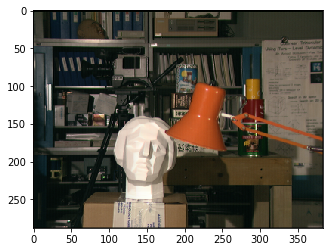

In [65]:
plt.imshow(img2,cmap='bone')

In [66]:
def gaussian_kernel(k=3,sigma=.3):
    x,y = np.mgrid[-k//2:k//2,-k//2:k//2]+1
    kernel = np.exp(-(x**2 +y**2)/(2*sigma**2))
    return kernel/kernel.sum()

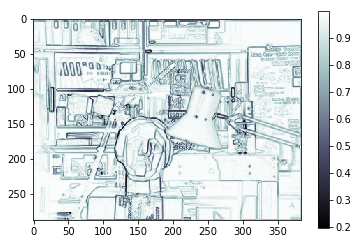

In [67]:
def squash(img):
    a = (0,1)
    return (img - np.amin(img,axis=a))/(np.amax(img,axis=a)-np.amin(img,axis=a))


lap_2d = np.array([[ 0,-1, 0],[-1, 4,-1],[ 0,-1, 0]])
Dx = np.array([[-1/2,0,1/2]])
Dy = Dx.T
bimg2 = img1#bimg2 = conv(img2,gaussian_kernel(sigma=1)[...,None])
edgex = np.linalg.norm(conv(bimg2,Dx[...,None]),axis=-1)
edgey = np.linalg.norm(conv(bimg2,Dy[...,None]),axis=-1)
remap = lambda img: np.exp(-2*conv(img,gaussian_kernel(k=3,sigma=.3)))

bedgex = remap(edgex)
bedgey = remap(edgey)
edges = np.sqrt(edgex**2+edgey**2)
#bedges = conv(edges,gaussian_kernel(k=9,sigma=15))
bedges = remap(edges)
plt.imshow(bedges,cmap='bone')
plt.colorbar()

In [68]:
alpha=3
D2 = laplacian_op(disps.shape)
I = identity_op(disps.shape)
d2x = np.array([[-1,2,-1]])
d2y = d2x.T
D2x = convolve_op(d2x,disps.shape)
D2y = convolve_op(d2y,disps.shape)
#G = convolve_op(gaussian_kernel(sigma=.3),disps.shape)
# dx = np.array([[-1/2,0,1/2]])
# Dx = convolve_op(dx,disps.shape)
# Dy = convolve_op(dx.T,disps.shape)
Qx = I#diag_op(bedgex)
Qy = I#diag_op(bedgey)
Q = diag_op(bedges)
y_var = I
A = (y_var+alpha*Qx*D2x*Qx + alpha*Qy*D2y*Qy)
map_disp = sp.sparse.linalg.cg(A,y_var(disps.reshape(-1)),maxiter=100)[0].reshape((h,w))

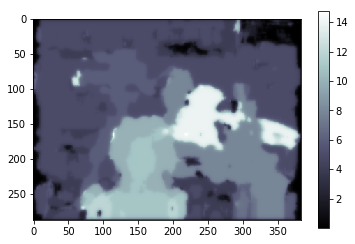

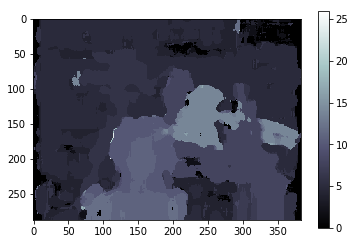

In [69]:
plt.imshow(map_disp,cmap='bone')
plt.colorbar()
plt.show()
plt.imshow(disps,cmap='bone')
plt.colorbar()
plt.show()

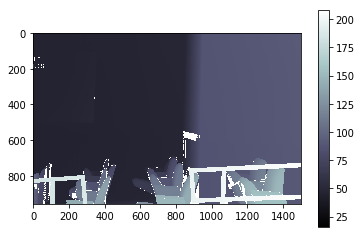

In [174]:
plt.imshow(gt_depth,cmap='bone')
plt.colorbar()

In [ ]:
#sp.ndimage.correlate(padded_im2[...,None],qq)

In [ ]:
#sp.signal.convolve(padded_im2[...,None],qq,mode='valid')

In [ ]:
ws = 9
h,w,c = img1.shape
cropped = img1[:h-h%ws,:w-w%ws,:]
h,w,c = cropped.shape
rr = cropped.reshape((ws,h//ws,w,c),order='F').reshape((ws,h//ws,ws,w//ws,c),order='F')
qq = rr.transpose((0,2,4,1,3)).reshape((ws,ws,c,-1),order='F')
tqq = torch.from_numpy(qq.transpose((3,2,0,1)))
tim2 = torch.from_numpy(img2.transpose((2,0,1))[None,...])